In [1]:
import sys
sys.path.append("/Users/philippvonbachmann/Documents/University/WiSe2122/ResearchProject/ResearchProjectLLVI")
from TyXe import tyxe
from torch import nn
from pyro import distributions as dist
import pyro
import pyro.infer.autoguide as ag
import torch
from BasicExample.datasets.Regression.toydataset import create_dataset, sinus_mapping, dataset_to_loader
from matplotlib import pyplot as plt
import functools

In [2]:
data_noise = 0.2
n_datapoints = 256
x_train, y_train, x_test, y_test = create_dataset(lower=-5, upper=7, mapping=sinus_mapping,cluster_pos=[-0.5,2], data_noise=data_noise, n_datapoints=n_datapoints)
x_test = torch.unsqueeze(x_test, dim=-1)

# batch train set
train_set, test_set = dataset_to_loader(x_train, y_train, x_test, y_test , batch_size=16)

torch.manual_seed(1)
net = nn.Sequential(nn.Linear(1, 200), nn.Tanh(), nn.Linear(200, 100), nn.Tanh(), nn.Linear(100, 1))
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))
kl_div_scaling_factor=10
likelihood = tyxe.likelihoods.HomoskedasticGaussian(n_datapoints * kl_div_scaling_factor, scale=0.2)
inference = tyxe.guides.AutoNormal
# inference = ag.AutoDiagonalNormal#lambda model: ag.AutoLowRankMultivariateNormal(model, init_scale=1.)
bnn = tyxe.VariationalBNN(net, prior, likelihood, inference)

optim = pyro.optim.Adam({"lr": 1e-3})
epochs=1000
def print_epoch(_, epoch, elbo):
    if (epoch % 10 ) == 0:
        print(f"Epoch {epoch}, ELBO loss {elbo} ", end="\r")

with tyxe.poutine.local_reparameterization():
    bnn.fit(train_set, optim, epochs, callback=print_epoch)

predictions= []
for i in range(x_test.shape[0]):
    predictions.append(bnn.predict(x_test[i], num_predictions=100))

predictions = torch.tensor(predictions)

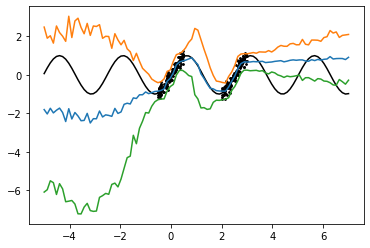

In [4]:
fig, ax = plt.subplots()
ax.plot(x_test, y_test, color="black", label="True function")
ax.scatter(x_train, y_train, s=3, color="black")
mean = predictions[:,0]
std = predictions[:,1]
ax.plot(x_test, mean)
ax.plot(x_test, mean + 2 * std)
ax.plot(x_test, mean - 2 * std)